Examining the code, we see that
when the button is clicked, the ``set_value()`` function is called, which
constructs a simple Python statement
assigning ``var_value`` to the variable given by ``var_name``.  As mentioned
above, the key to interaction between Javascript and the notebook kernel is to use
the ``IPython.notebook.kernel.execute()`` command, passing valid Python
code in a string.  We also log the result to the javascript console, which
can be helpful for Javascript debugging.

## Accessing Python Output In Javascript

Executing Python statements from Javascript is one thing, but we'd
really like to be able to do something with the output.

In order to process the output of a Python statement executed in the kernel,
we need to add a callback function to the ``execute`` statement.
The full extent of callbacks is a bit involved, but the first step is
to set a callback which does something with the ``output`` attribute.

To set an output, we pass a Javascript callback object to the
execute call, looking like this:

    var kernel = IPython.notebook.kernel;
    function callback(out_type, out_data){
        // do_something
    }
    kernel.execute(command, {"output": callback});

Using this, we can execute a Python command and do something with
the result.  The python command can be as simple as a variable name:
in this case, the value returned is simply the value of that variable.

To demonstrate this, we'll first import ``pi`` and ``sin``
from the ``math`` package in Python:

In [1]:
from math import pi, sin

In [2]:
from IPython.display import HTML


And then we'll manipulate this value via Javascript:

In [3]:
# Add an input form similar to what we saw above
input_form = """
<div style="background-color:gainsboro; border:solid black; width:600px; padding:20px;">
Code: <input type="text" id="code_input" size="50" height="2" value="sin(pi / 2)"><br>
Result: <input type="text" id="result_output" size="50" value="1.0"><br>
<button onclick="exec_code()">Execute</button>
</div>
"""

# here the javascript has a function to execute the code
# within the input box, and a callback to handle the output.
javascript = """
<script type="text/Javascript">
    function handle_output(out_type, out){
        console.log(out_type);
        console.log(out);
        var res = null;
         // if output is a print statement
        if(out_type == "stream"){
            res = out.data;
        }
        // if output is a python object
        else if(out_type === "pyout"){
            res = out.data["text/plain"];
        }
        // if output is a python error
        else if(out_type == "pyerr"){
            res = out.ename + ": " + out.evalue;
        }
        // if output is something we haven't thought of
        else{
            res = "[out type not implemented]";   
        }
        document.getElementById("result_output").value = res;
    }
    
    function exec_code(){
        var code_input = document.getElementById('code_input').value;
        var kernel = IPython.notebook.kernel;
        var callbacks = {'output' : handle_output};
        document.getElementById("result_output").value = "";  // clear output box
        var msg_id = kernel.execute(code_input, callbacks, {silent:false});
        console.log("button pressed");
    }
</script>
"""

HTML(input_form + javascript)

Pressing <button>Execute</button> above will call ``kernel.execute``
with the contents of the **Code** box, passing a callback which
displays the result in the result box.

The reason the callback has so many conditionals is because there are several types
of outputs we need to handle.  Note that the output handler is given as the ``output``
attribute of a Javascript object, and passed to the ``kernel.execute`` function.
Again, we use ``console.log`` to allow us to inspect the objects
using the Javascript console.

## Application: An On-the-fly Matplotlib Animation

In a [previous post](http://jakevdp.github.io/blog/2013/05/19/a-javascript-viewer-for-matplotlib-animations/)
I introduced a javascript viewer for matplotlib animations. This viewer pre-computes all the matplotlib
frames, embeds them in the notebook, and offers some tools to view them.

Here we'll explore a different strategy: rather than precomputing all the frames before displaying them,
we'll use the javascript/python kernel communication and *generate the frames as needed*.

Note that if you're viewing this statically (e.g. in nbviewer or on my blog), it will be relatively
unexciting: with no IPython kernel available, calls to the kernel will do nothing.
To see this in action, please
[download](http://jakevdp.github.io/downloads/notebooks/JSInteraction.ipynb) the notebook and open it with a running IPython notebook instance.

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pi', 'sin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
from IPython.display import HTML
#from cStringIO import StringIO
from io import StringIO

# We'll use HTML to create a control panel with an
# empty image and a number of navigation buttons.

disp_html = """
<div class="animation" align="center">
<img id="anim_frame" src=""><br>
<button onclick="prevFrame()">Prev Frame</button>
<button onclick="reverse()">Reverse</button>
<button onclick="pause()">Pause</button>
<button onclick="play()">Play</button>
<button onclick="nextFrame()">Next Frame</button>
</div>
"""

# now the javascript to drive it.  The nextFrame() and prevFrame()
# functions will call the kernel and pull-down the frame which
# is generated.  The play() and reverse() functions use timeouts
# to repeatedly call nextFrame() and prevFrame().

javascript = """
<script type="text/Javascript">
var count = -1;  // keep track of frame number
var animating = 0;  // keep track of animation direction
var timer = null;
var kernel = IPython.notebook.kernel;

function output(out_type, out){
    data = out.data["text/plain"];
    document.getElementById("anim_frame").src = data.substring(1, data.length - 1);
    
    if(animating > 0){
        timer = setTimeout(nextFrame, 0);
    }
    else if(animating < 0){
        timer = setTimeout(prevFrame, 0);
    }
}

var callbacks = {'output' : output};

function pause(){
    animating = 0;
    if(timer){
        clearInterval(timer);
        timer = null;
    }
}

function play(){
    pause();
    animating = +1;
    nextFrame();
}

function reverse(){
    pause();
    animating = -1;
    prevFrame();
}

function nextFrame(){
    count += 1;
    var msg_id = kernel.execute("disp._get_frame_data(" + count + ")", callbacks, {silent:false});
}

function prevFrame(){
    count -= 1;
    var msg_id = kernel.execute("disp._get_frame_data(" + count + ")", callbacks, {silent:false});
}

// display the first frame
setTimeout(nextFrame, 0);

</script>
"""

# Here we create a class whose HTML representation is the above
# HTML and javascript.  Note that we've hard-coded the global
# variable name `disp` in the Javascript, so you'll have to assign
# the resulting object to this name in order to view it.

class DisplayAnimation(object):
    def __init__(self, anim):
        self.anim = anim
        self.fig = anim._fig
        plt.close(self.fig)
        
    def _get_frame_data(self, i):
        anim._draw_frame(i)
        buffer = StringIO()
        fig.savefig(buffer, format='png')
        buffer.reset()
        data = buffer.read().encode('base64')
        return "data:image/png;base64,{0}".format(data.replace('\n', ''))
    
    def _repr_html_(self):
        return disp_html + javascript

This code should be considered a proof-of-concept: in particular, it
requires the display object to be named ``disp`` in the global namespace.
But making it more robust would be a relatively simple process.

Here we'll test the result by creating a simple animation and displaying it dynamically:

In [6]:
from matplotlib import animation

fig = plt.figure()
ax = plt.axes(xlim=(0, 10), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    x = np.linspace(0, 10, 1000)
    y = np.cos(i * 0.02 * np.pi) * np.sin(x - i * 0.02 * np.pi)
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30)

# For now, we need to name this `disp` for it to work
disp = DisplayAnimation(anim)
disp

Once again, if you're viewing this statically, you'll see nothing above
the buttons.  The kernel needs to be running in order to see this: you can
[download the notebook](http://jakevdp.github.io/downloads/notebooks/JSInteraction.ipynb) and run it to see the results (To see a
statically-viewable version of the animation, refer to the
[previous post](http://jakevdp.github.io/blog/2013/05/19/a-javascript-viewer-for-matplotlib-animations/)).
But I assure you,
it works!  We've created an animation viewer which uses bi-directional
communication between javascript and matplotlib to generate the frames in
real-time.

Note that this is still rather limited, and should be considered a proof-of-concept
more than a finished result.  In particular, on my four-year-old linux box, I
can only achieve a frame-rate of about 10 frames/sec.
Part of this is due to the reliance on png images saved within matplotlib,
as we can see by profiling the function:

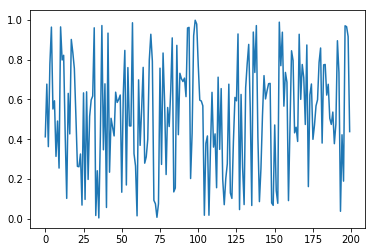

In [7]:
def save_to_mem(fig):
    buffer = StringIO()
    fig.savefig(buffer, format='png')
    buffer.reset()
    data = buffer.read().encode('base64')
    return "data:image/png;base64,{0}".format(data.replace('\n', ''))

fig, ax = plt.subplots()
ax.plot(rand(200))

In [8]:
%timeit save_to_mem(fig)

TypeError: string argument expected, got 'bytes'

That's a cap of about 20 frames per second on matplotlib's end, not including
the time required to serialize and send the data,
or to render each frame on the page.
I'm certain there are much better ways to do this particular application,
but they would take a bit more thought.

I hope this post was helpful to you, as unpolished as the results are, and
please let me know if you have ideas about how to do this more effectively!
Also, keep in mind that Javascript support should be improving immensely in
IPython 2.0, which (according to the [roadmap](https://github.com/ipython/ipython/wiki/Roadmap:-IPython))
should be released in December of 2013.  At that point I may have more to say
on the subject!

*This post was composed entirely in IPython notebook.*
*The source notebook can be downloaded*
[here](http://jakevdp.github.io/downloads/notebooks/JSInteraction.ipynb)